In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('telco-customer-churn.csv')
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset: 7043 rows, 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### Data Cleaning

In [3]:
# Fix TotalCharges (contains empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Convert target to binary
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

print(f"Churn rate: {df['churn'].mean():.1%}")
df.info()

Churn rate: 26.5%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 n

##### EDA - Missing Values & Statistic

In [4]:
print(df.isnull().sum()[df.isnull().sum() > 0])

numerical_cols = ['tenure', 'monthlycharges', 'totalcharges']
df[numerical_cols].describe()

Series([], dtype: int64)


,tenure,monthlycharges,totalcharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


##### EDA - Target Variable Analysis

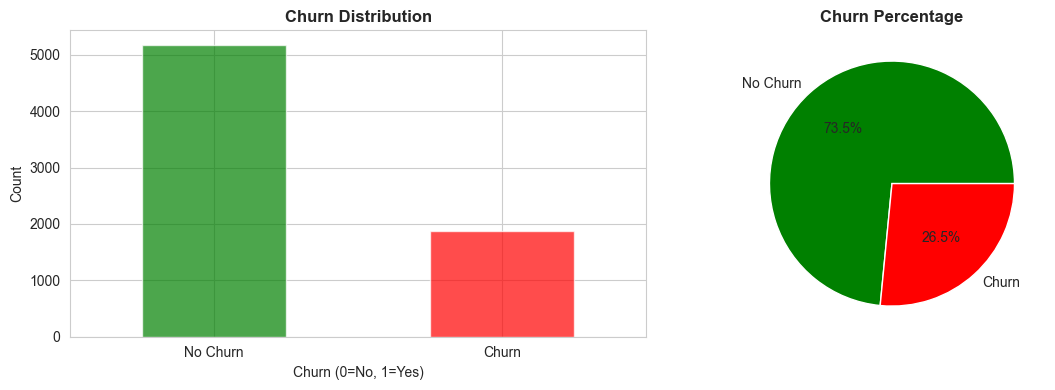

Churn rate: 26.5% (1,869 customers)


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['churn'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Churn Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Churn (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Churn', 'Churn'], rotation=0)

# Pie chart
df['churn'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                colors=['green', 'red'], labels=['No Churn', 'Churn'])
axes[1].set_ylabel('')
axes[1].set_title('Churn Percentage', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Churn rate: {df['churn'].mean():.1%} ({df['churn'].sum():,} customers)")

##### EDA - Numerical Features

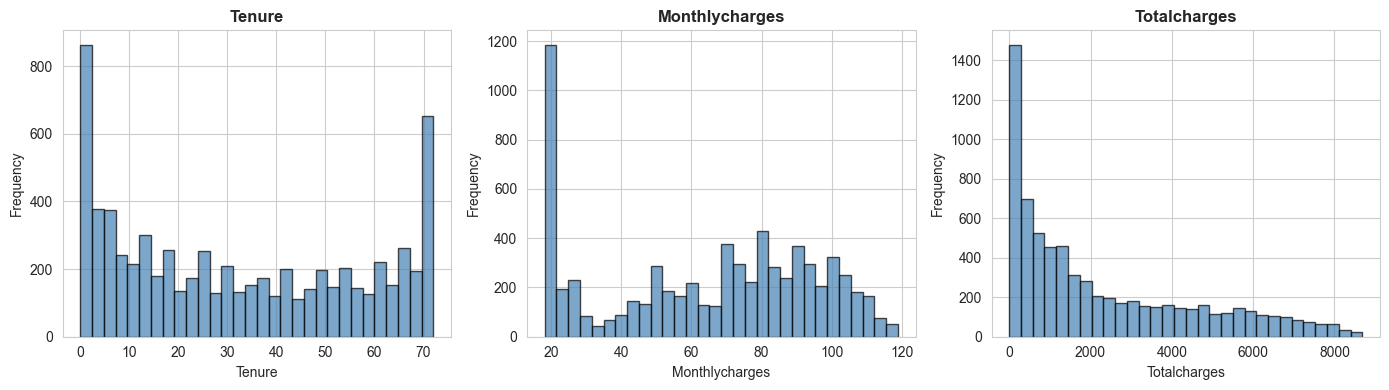

In [6]:
# Distribution of numerical features
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col.title()}', fontweight='bold')
    axes[i].set_xlabel(col.title())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### EDA - Categorical Features Analysis

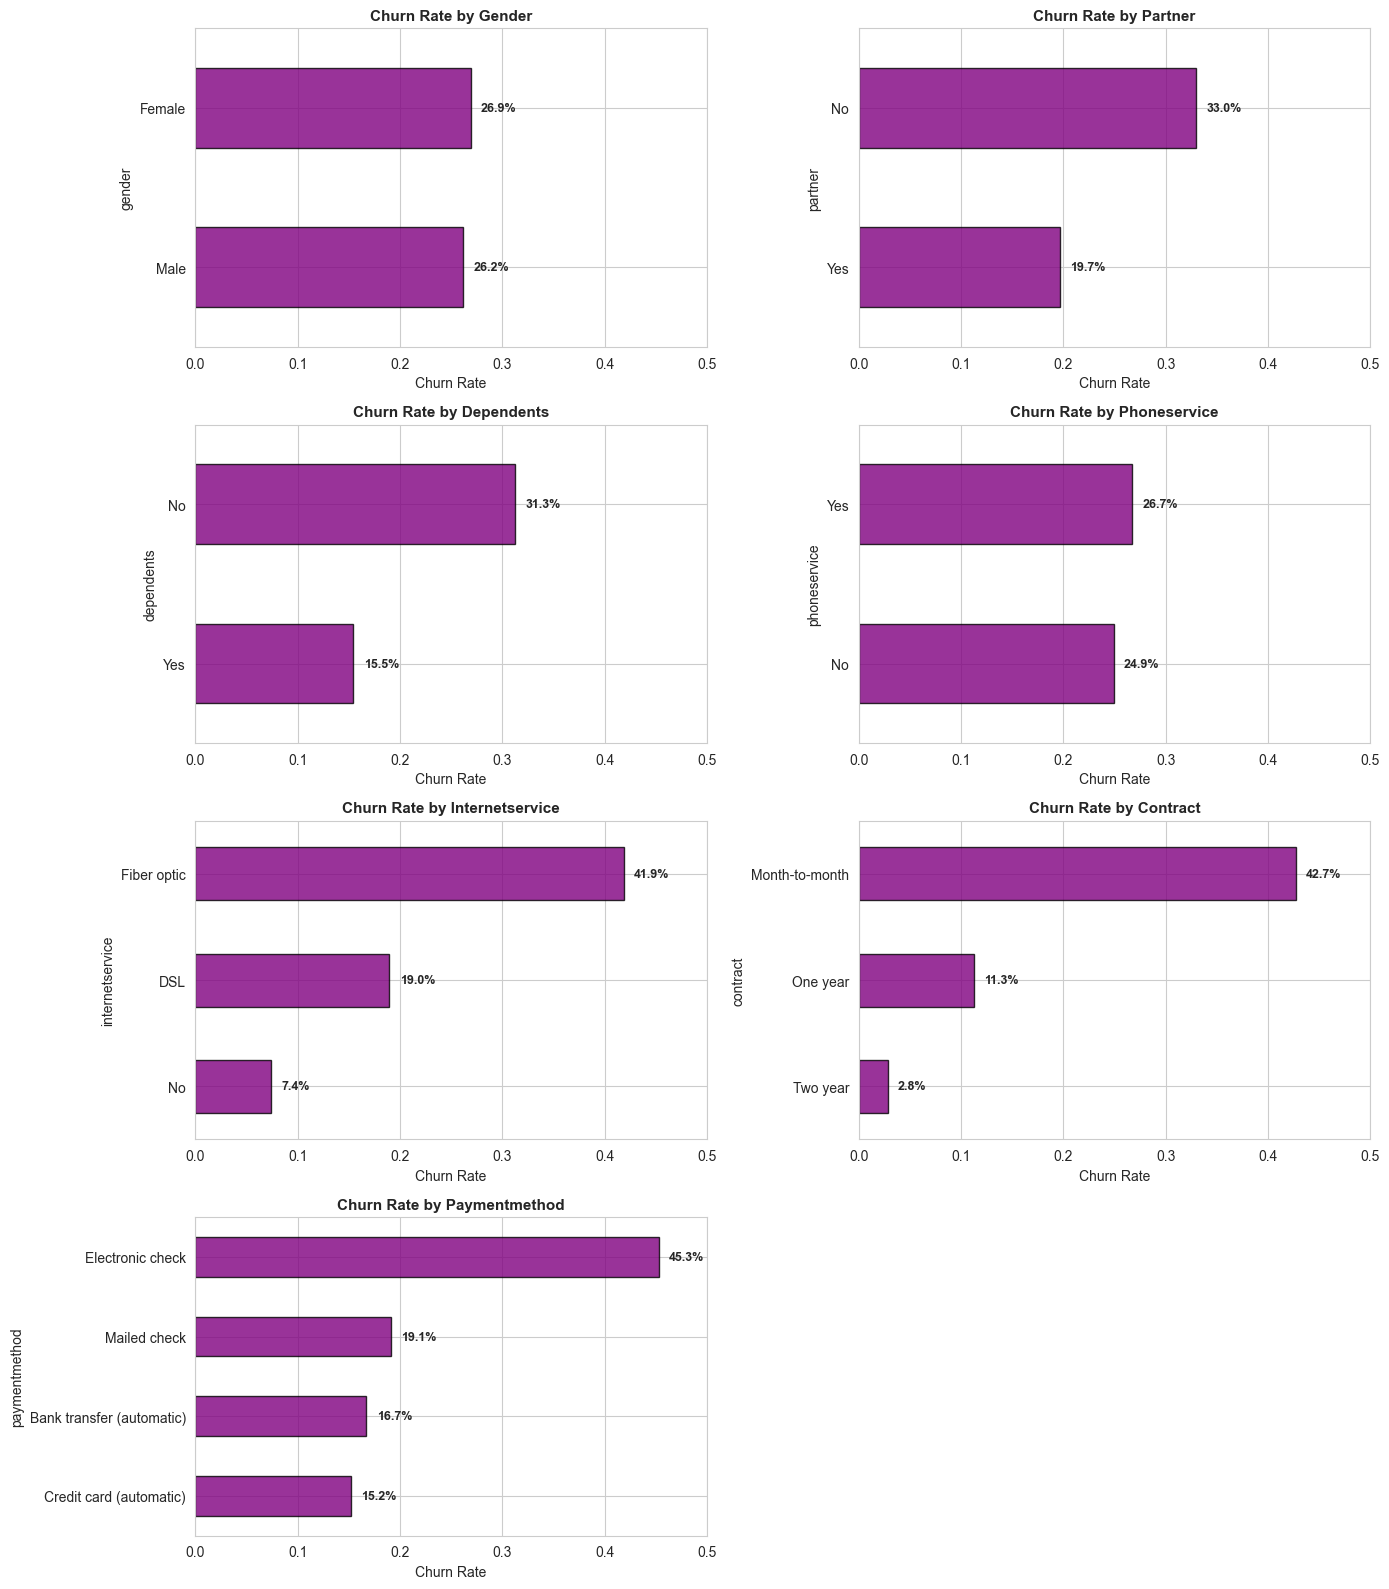

Key Insights:
• Month-to-month contracts: 42.7% churn
• Fiber optic internet: 41.9% churn
• Electronic check payment: 45.3% churn


In [7]:
categorical_features = ['gender', 'partner', 'dependents', 'phoneservice', 
                        'internetservice', 'contract', 'paymentmethod']

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.ravel()

for i, col in enumerate(categorical_features):
    churn_rate = df.groupby(col)['churn'].agg(['sum', 'count', 'mean']).sort_values('mean')
    
    churn_rate['mean'].plot(kind='barh', ax=axes[i], color='purple', edgecolor='black', alpha=0.8)
    axes[i].set_title(f'Churn Rate by {col.title()}', fontweight='bold', fontsize=11)
    axes[i].set_xlabel('Churn Rate')
    axes[i].set_xlim(0, 0.5)
    
    # Add percentage labels
    for idx, v in enumerate(churn_rate['mean'].values):
        axes[i].text(v + 0.01, idx, f'{v:.1%}', va='center', fontweight='bold', fontsize=9)

axes[7].axis('off')
plt.tight_layout()
plt.show()

# Print key insights
print("Key Insights:")
print(f"• Month-to-month contracts: {df[df['contract']=='Month-to-month']['churn'].mean():.1%} churn")
print(f"• Fiber optic internet: {df[df['internetservice']=='Fiber optic']['churn'].mean():.1%} churn")
print(f"• Electronic check payment: {df[df['paymentmethod']=='Electronic check']['churn'].mean():.1%} churn")

##### Feature Importance - Correlation Analysis

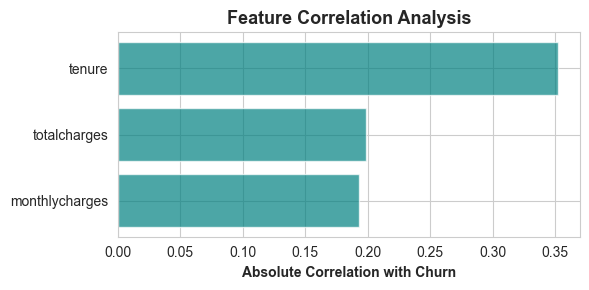

Correlation with Churn:
       feature  correlation
        tenure     0.352229
  totalcharges     0.198324
monthlycharges     0.193356


In [8]:
correlations = []

for col in numerical_cols:
    corr = df[col].corr(df['churn'])
    correlations.append({'feature': col, 'correlation': abs(corr)})

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)

plt.figure(figsize=(6, 3))
plt.barh(corr_df['feature'], corr_df['correlation'], color='teal', alpha=0.7)
plt.xlabel('Absolute Correlation with Churn', fontweight='bold')
plt.title('Feature Correlation Analysis', fontweight='bold', fontsize=13)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Correlation with Churn:")
print(corr_df.to_string(index=False))

##### Feature Engineering

In [9]:
# Create new features
df['tenure_group'] = pd.cut(df['tenure'], 
                            bins=[0, 12, 24, 48, 72], 
                            labels=['0-1yr', '1-2yr', '2-4yr', '4+yr'])
df['tenure_group'] = df['tenure_group'].astype(str)

df['avg_monthly_charge'] = df['totalcharges'] / (df['tenure'] + 1)
df['has_internet'] = (df['internetservice'] != 'No').astype(int)
df['has_phone'] = (df['phoneservice'] == 'Yes').astype(int)
df['is_senior'] = df['seniorcitizen']

# Count add-on services
services = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 
            'techsupport', 'streamingtv', 'streamingmovies']
df['total_services'] = df[services].apply(lambda x: (x == 'Yes').sum(), axis=1)

print("New features created: tenure_group, avg_monthly_charge, has_internet, has_phone, total_services")

New features created: tenure_group, avg_monthly_charge, has_internet, has_phone, total_services


##### Prepare Data - 60% / 20% / 20%

In [10]:
# Remove ID column
df_clean = df.drop('customerid', axis=1)

# Split features & target
X = df_clean.drop('churn', axis=1)
y = df_clean['churn']

# 60% train, 20% validation, 20% test
X_full, X_test, y_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.25, random_state=42, stratify=y_full)

print(f"Train: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation: {len(X_val):,} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

Train: 4,225 (60.0%)
Validation: 1,409 (20.0%)
Test: 1,409 (20.0%)


##### Feature Encoding

In [11]:
# Encode features
train_dicts = X_train.fillna('Missing').to_dict(orient='records')
val_dicts = X_val.fillna('Missing').to_dict(orient='records')
test_dicts = X_test.fillna('Missing').to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_enc = dv.fit_transform(train_dicts)
X_val_enc = dv.transform(val_dicts)
X_test_enc = dv.transform(test_dicts)

print(f"Features: {X_train.shape[1]} → {X_train_enc.shape[1]} (after one-hot encoding)")

Features: 25 → 55 (after one-hot encoding)


##### Model Training - Logistic Regression

In [12]:
# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr.fit(X_train_enc, y_train)

y_pred_lr_train = lr.predict_proba(X_train_enc)[:, 1]
y_pred_lr_val = lr.predict_proba(X_val_enc)[:, 1]

lr_train_auc = roc_auc_score(y_train, y_pred_lr_train)
lr_val_auc = roc_auc_score(y_val, y_pred_lr_val)

print(f"Logistic Regression:")
print(f"Training AUC: {lr_train_auc:.4f}")
print(f"Validation AUC: {lr_val_auc:.4f}")

Logistic Regression:
Training AUC: 0.8557
Validation AUC: 0.8398


##### Model Training - Decision Tree

In [13]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, random_state=42)
dt.fit(X_train_enc, y_train)

y_pred_dt_val = dt.predict_proba(X_val_enc)[:, 1]
dt_val_auc = roc_auc_score(y_val, y_pred_dt_val)

print(f"Decision Tree:")
print(f"Validation AUC: {dt_val_auc:.4f}")

Decision Tree:
Validation AUC: 0.8207


##### Model Training - Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=30, 
                           random_state=42, n_jobs=-1)
rf.fit(X_train_enc, y_train)

y_pred_rf_val = rf.predict_proba(X_val_enc)[:, 1]
rf_val_auc = roc_auc_score(y_val, y_pred_rf_val)

print(f"Random Forest:")
print(f"Validation AUC: {rf_val_auc:.4f}")

Random Forest:
Validation AUC: 0.8380


##### Model Training - XGBoost

In [15]:
dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dval = xgb.DMatrix(X_val_enc, label=y_val)

xgb_params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.3,
    'seed': 42,
    'eval_metric': 'auc'
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=50, 
                      evals=[(dval, 'val')], verbose_eval=False)

y_pred_xgb_val = xgb_model.predict(dval)
xgb_val_auc = roc_auc_score(y_val, y_pred_xgb_val)

print(f"XGBoost:")
print(f"Validation AUC: {xgb_val_auc:.4f}")

XGBoost:
Validation AUC: 0.8192


##### Model Comparison

Model Comparison:
              Model  Validation AUC
Logistic Regression        0.839827
      Random Forest        0.837983
      Decision Tree        0.820689
            XGBoost        0.819189


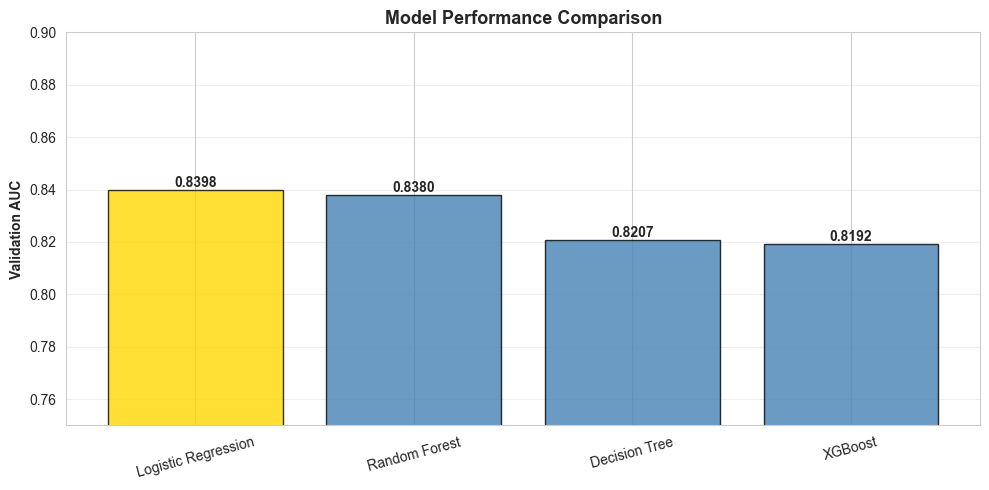

In [16]:
results = {
    'Logistic Regression': lr_val_auc,
    'Decision Tree': dt_val_auc,
    'Random Forest': rf_val_auc,
    'XGBoost': xgb_val_auc
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Validation AUC'])
results_df = results_df.sort_values('Validation AUC', ascending=False)

print("Model Comparison:")
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 5))
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(results_df))]
bars = plt.bar(results_df['Model'], results_df['Validation AUC'], 
               color=colors, edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Validation AUC', fontweight='bold')
plt.title('Model Performance Comparison', fontweight='bold', fontsize=13)
plt.ylim(0.75, 0.90)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##### Hyperparameter Tuning

In [17]:
# Tune XGBoost (best model)
best_auc = 0
best_params = {}

print("Hyperparameter Tuning for XGBoost:")
for depth in [4, 6, 8]:
    for eta in [0.1, 0.3, 0.5]:
        params = {
            'objective': 'binary:logistic',
            'max_depth': depth,
            'eta': eta,
            'seed': 42,
            'eval_metric': 'auc'
        }
        
        model = xgb.train(params, dtrain, num_boost_round=50, 
                         evals=[(dval, 'val')], verbose_eval=False)
        auc = roc_auc_score(y_val, model.predict(dval))
        
        print(f"  depth={depth}, eta={eta:.1f} → AUC: {auc:.4f}")
        
        if auc > best_auc:
            best_auc = auc
            best_params = params

print(f"\n Best parameters: {best_params}")
print(f" Best validation AUC: {best_auc:.4f}")

Hyperparameter Tuning for XGBoost:
  depth=4, eta=0.1 → AUC: 0.8404
  depth=4, eta=0.3 → AUC: 0.8307
  depth=4, eta=0.5 → AUC: 0.8208
  depth=6, eta=0.1 → AUC: 0.8384
  depth=6, eta=0.3 → AUC: 0.8192
  depth=6, eta=0.5 → AUC: 0.8110
  depth=8, eta=0.1 → AUC: 0.8289
  depth=8, eta=0.3 → AUC: 0.8198
  depth=8, eta=0.5 → AUC: 0.7990

 Best parameters: {'objective': 'binary:logistic', 'max_depth': 4, 'eta': 0.1, 'seed': 42, 'eval_metric': 'auc'}
 Best validation AUC: 0.8404


##### Train Final Model

In [18]:
# Train on full training data (train + validation)
X_full_enc = np.vstack([X_train_enc, X_val_enc])
y_full_all = np.concatenate([y_train, y_val])

dfull = xgb.DMatrix(X_full_enc, label=y_full_all)
dtest = xgb.DMatrix(X_test_enc, label=y_test)

final_model = xgb.train(best_params, dfull, num_boost_round=50)

# Evaluate on test set
y_pred_test = final_model.predict(dtest)
test_auc = roc_auc_score(y_test, y_pred_test)

y_pred_class = (y_pred_test >= 0.5).astype(int)
test_acc = accuracy_score(y_test, y_pred_class)

print("Final Model - Test set perfomance")
print(f"AUC:      {test_auc:.4f}")
print(f"Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=['No Churn', 'Churn']))

Final Model - Test set perfomance
AUC:      0.8450
Accuracy: 0.8062

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.91      0.87      1035
       Churn       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



##### Confusion Matrix

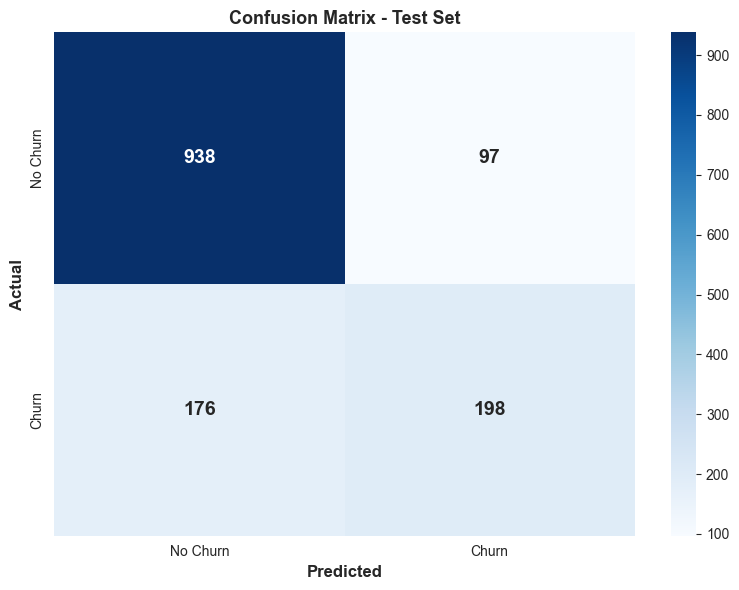

In [19]:
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'],
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

##### Feature Importance - Final Model

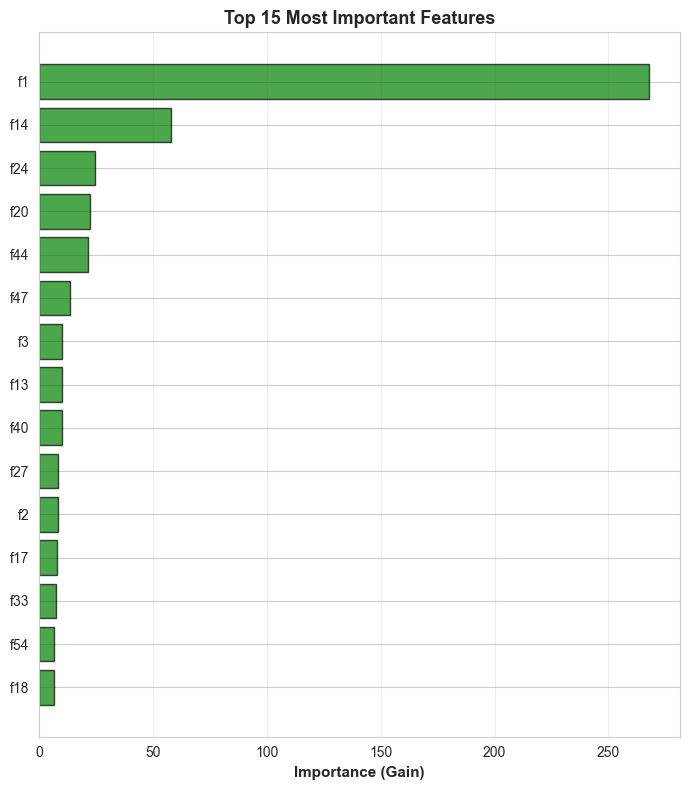

Top 15 Features:
feature  importance
     f1  268.055206
    f14   58.076759
    f24   24.404806
    f20   22.255814
    f44   21.498646
    f47   13.412792
     f3   10.180109
    f13   10.122635
    f40   10.014294
    f27    8.388089
     f2    8.191886
    f17    7.604598
    f33    7.469116
    f54    6.668805
    f18    6.369445


In [20]:
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(7, 8))
plt.barh(importance_df['feature'], importance_df['importance'], 
         color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Importance (Gain)', fontsize=11, fontweight='bold')
plt.title('Top 15 Most Important Features', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 15 Features:")
print(importance_df.head(15).to_string(index=False))

In [21]:
# Save model and encoder
final_model.save_model('model.json')

with open('dv.pkl', 'wb') as f:
    pickle.dump(dv, f)